In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_bls(all_time, all_flux, all_time_binned, all_flux_binned, model, results, period, duration, t0, mid_transit_t0, in_transit = [0], in_transit_notbinned = [0], lc_phased = None, lc_phased_binned = None):
    """
    Plot the BLS. This functinon is called in data_bls().

    Parameters
    ----------
    all_time  :  list
        times (not binned)
    all_flux  :  list
        normalized flux (not binned)
    all_time_binned  :  list
        binned time
    all_flux_binned  :  list
        normalized binned flux
    model :  float
        the transit model at the given period, duration, and phase
    results :  class
        results from the BLS fitting routine
    period :  float
        the period of the "most-likely" transits
    duration :  float
        the duration of the transit
    t0  :  float
        the mid-transit time of the reference transit
    in_transit = [0] :  float
        if this is [0] (by deafult), the code knows that this is the initial run i.e. no transits have been removes (+ results are plotted in different colors)
    in_transit_notbinned = [0]. :  float
        if this is [0] (by deafult), the code knows that this is the initial run i.e. no transits have been removes (+ results are plotted in different colors)
    lc_phased = None : lc
        lc not binned object (optional)
    lc_phased_binned = None : lc
        lc binned object (optional)

    Returns
    -------
        Plot the results from the BLS with three pannels: periodgram, best fit model to the transits, phase folded fit.
    """

    if len(in_transit) == 1:  # conditions for the first "round" of plotting
        # define the colours of the plot
        color1 = "#DC143C"
        color2 = "darkorange"
        title = "Initial BLS"

    else:  # conditions for the second "round" of plotting once the first event has been removed
        # define the colours of the plot
        color1 = "deepskyblue"
        color2 = "#4682B4"
        title = "Event removed"
        
    number_plots = 4 if lc_phased is not None and lc_phased_binned is not None else 3
    
    fig, axes = plt.subplots(number_plots, 1, figsize=(5, 7))

    # highlight the harmonics of the peak period
    ax = axes[0]
    ax.axvline(period, alpha=0.4, lw=5, color = color1)
    for n in range(2, 15):
        ax.axvline(n*period, alpha=0.4, lw=2, linestyle="dashed", color = color2) # plot the harmonics
        ax.axvline(period / n, alpha=0.4, lw=2, linestyle="dashed", color = color2)

    # ------------
    # plot the periodogram
    ax.plot(results.period, results.power, "k", lw=0.5, label = "P = %.3f T0 = %.3f" % (period,mid_transit_t0))
    ax.set_title(title)
    ax.set_xlim(results.period.min(), results.period.max())
    ax.set_xlabel("period (days)")
    ax.set_ylabel("log likelihood")
    ax.legend(fontsize = 10, loc = 1)

    # ------------
    # plot the light curve and best-fit model
    ax = axes[1]

    if len(in_transit) == 1:  # for the initial run
        ax.plot(all_time, all_flux, marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, markerfacecolor = "none")
        ax.plot(all_time_binned, all_flux_binned, marker ="o", alpha = 0.6, color = "black", ms=3, lw = 0, markerfacecolor = "none")
    else:  # for the second run (once the first "event" has been removed)
        ax.plot(all_time[~in_transit_notbinned], all_flux[~in_transit_notbinned], marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, markerfacecolor = "none")
        ax.plot(all_time_binned[~in_transit], all_flux_binned[~in_transit], marker ="o", alpha = 0.6, color = "black",  markerfacecolor = "none", ms=3, lw = 0)

    x = np.linspace(all_time_binned.min(), all_time_binned.max(), 3*len(all_time_binned))
    f = model.model(x, period, duration, t0)
    ax.plot(x, f, lw=2, color = color1)
    ax.set_xlim(all_time_binned.min(), all_time_binned.max())
    ax.set_xlabel("time (days)")
    ax.set_ylabel("de-trended flux (ppt)");

    # ------------
    ax = axes[2]
    if len(in_transit) == 1:  # for the initial run
        x_binned = (all_time_binned - t0 + 0.5*period) % period - 0.5*period
        x = (all_time - t0 + 0.5*period) % period - 0.5*period
    else: # for the second run (once the first "event" has been removed)
        x_binned = (all_time_binned[~in_transit] - t0 + 0.5*period) % period - 0.5*period
        x = (all_time[~in_transit_notbinned] - t0 + 0.5*period) % period - 0.5*period

    m_binned = np.abs(x_binned) < 0.5
    m = np.abs(x) < 0.5

    # plot the data
    if len(in_transit) == 1:  # for the initial run
        ax.plot(x[m], all_flux[m],marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, markerfacecolor = "none")
        ax.plot(x_binned[m_binned], all_flux_binned[m_binned], marker ="o", alpha = 0.6, color = "black", ms=3, lw = 0, markerfacecolor = "none")

    else: # for the second run (once the first "event" has been removed)
        ax.plot(x[m], all_flux[~in_transit_notbinned][m],marker =".", alpha = 0.4, color = color2, ms=2, lw = 0, markerfacecolor = "none")
        ax.plot(x_binned[m_binned], all_flux_binned[~in_transit][m_binned], marker ="o", alpha = 0.6, color = "black", ms=3, lw = 0, markerfacecolor = "none")

    x = np.linspace(-0.5, 0.5, 1000)
    f = model.model(x + t0, period, duration, t0)
    ax.plot(x, f, lw=2, color = color1)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xlabel("time since transit (days)")
    ax.set_ylabel("de-trended flux (ppt)")
    plt.tight_layout()

     # ------------
    if number_plots == 4:
        ax = axes[3]
        
        # plot the data
        lc_phased.plot(ax = ax, marker = ".", alpha = 0.4, color = color2, ms=2, lw = 0, markerfacecolor = "none", label = "")
        lc_phased_binned.plot(ax = ax, marker = "o", alpha = 0.6, color = "black", ms=3, lw = 0, markerfacecolor = "none", label = "")
        
        ax.set_xlim(-2, 2)
        ax.set_ylim(0.996, 1.004)
        #plt.tight_layout()

    plt.show()

In [3]:
def data_bls(lc, n_iterations = 2):
    """
    function that runs the BLS routine and plots the results. The BLS is run twice and in the second
    the most significant result found in the first run is removed.
    Prior to running the BLS the data is detrended.

    Parameters
    ----------
    lc: from lightkurve for one or more sectors 

    Returns
    -------
        two lists of the statistics of the to BLS runs. Each list contains:
    stats_period
    stats_t0
    stats_depth
    stats_depth_phased
    stats_depth_half
    stats_depth_odd
    stats_depth_even
    """
    
    # normalize the data
    try:
        lc = lc.normalize()
    except:
        lc = lc.stitch()

    all_time = lc.time.value
    all_flux = lc.flux.value

    lc_bin = lc.bin(15/60/24)
    all_time_binned = lc_bin.time.value
    all_flux_binned = lc_bin.flux.value

    # make sure that there are no nan (empty) values in the data - they cause everything to crash so let"s get rid of them
    mask_binned = np.isfinite(all_time_binned) * np.isfinite(all_flux_binned)
    mask = np.isfinite(all_time) * np.isfinite(all_flux)

    all_time_binned = np.array(all_time_binned)[mask_binned]
    all_flux_binned = np.array(all_flux_binned)[mask_binned]
    all_time = np.array(all_time)[mask]
    all_flux = np.array(all_flux)[mask]

    # -------------------

    # detrend the data before running the BLS

    mask_binned = np.isfinite(all_time_binned) * np.isfinite(all_flux_binned)
    all_time_binned = np.array(all_time_binned)[mask_binned]
    all_flux_binned = np.array(all_flux_binned)[mask_binned]
    # -----------------------

    durations = np.linspace(0.05, 0.5, 15) # ????? CHECK THESE
    periods = np.arange(0.7, (np.nanmax(all_time_binned) - np.nanmin(all_time_binned)), 0.01)
    
    results_list = []

    prev_in_transit = np.zeros_like(all_time_binned, dtype=bool)
    prev_in_transit_notbinned = np.zeros_like(all_time, dtype=bool)

    for i in range(n_iterations):
        if len(all_time_binned[~prev_in_transit]) < 10:
            print(f"Stop in {i}, little data left.")
            break

        model = BoxLeastSquares(all_time_binned[~prev_in_transit], all_flux_binned[~prev_in_transit])
        results = model.power(periods, durations)

        index = np.argmax(results.power)
        period = results.period[index]
        t0 = results.transit_time[index]
        duration = results.duration[index]
        mid_transit_t0 = model.compute_stats(period, duration, t0)["transit_times"][0]

        if (1 * duration) >= period: # if the "found" events are very short period, don"t rn the BLS twice as the code would crash.
            results_list.append({
                "Period (days)": -999,
                "T0 (TBJD)": -999,
                "Transit depth (ppm)": -999,
                "Odd depth (ppm)": -999,
                "Even depth (ppm)": -999
            })
            break

        stats_period = period
        stats_t0 = mid_transit_t0
        stats_depth = model.compute_stats(period, duration, t0)["depth"]
        stats_depth_phased = model.compute_stats(period, duration, t0)["depth_phased"]
        stats_depth_half = model.compute_stats(period, duration, t0)["depth_half"]
        stats_depth_odd = model.compute_stats(period, duration, t0)["depth_odd"]
        stats_depth_even = model.compute_stats(period, duration, t0)["depth_even"]

        results_list.append({
            "Period (days)": stats_period,
            "T0 (TBJD)": stats_t0,
            "Transit depth (ppm)": stats_depth[0],
            "Odd depth (ppm)": stats_depth_odd[0],
            "Even depth (ppm)": stats_depth_even[0]
        })

        lc_phased = lc.fold(period = stats_period, epoch_time = stats_t0)
        
        lc_phased_binned = lc_phased.bin(15/60/24)

        if i == 0:
            plot_bls(all_time, all_flux, all_time_binned, all_flux_binned, model, results, period, duration, t0, mid_transit_t0, lc_phased = lc_phased, lc_phased_binned = lc_phased_binned)
        else:
            plot_bls(all_time, all_flux, all_time_binned, all_flux_binned, model, results, period, duration, t0, mid_transit_t0, in_transit=prev_in_transit, in_transit_notbinned=prev_in_transit_notbinned, lc_phased = lc_phased, lc_phased_binned = lc_phased_binned)

        # Find the in-transit points using a longer duration as a buffer to avoid ingress and egress
        in_transit = model.transit_mask(all_time_binned, period, 2*duration, t0)
        in_transit_notbinned = model.transit_mask(all_time, period, 2*duration, t0)

        prev_in_transit |= in_transit
        prev_in_transit_notbinned |= in_transit_notbinned

    
    df = pd.DataFrame(results_list)
    return df

In [24]:
sector_data = lk.search_lightcurve("TIC 50309957")[0]
# lc_collection = search_results.download_all().stitch()
# lc = search_results[0].download(quality_bitmask="hard"), author = ["SPOC", "TESS-SPOC"]

In [25]:
sector_data

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,GSFC-ELEANOR-LITE,1800,50309957,0.0


In [26]:
try:
    lc = sector_data.download_all()
except:
    lc = sector_data.download()

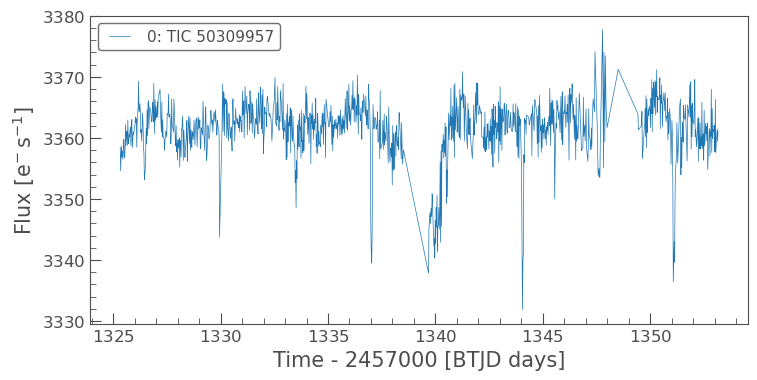

In [27]:
lc.plot()
plt.show()

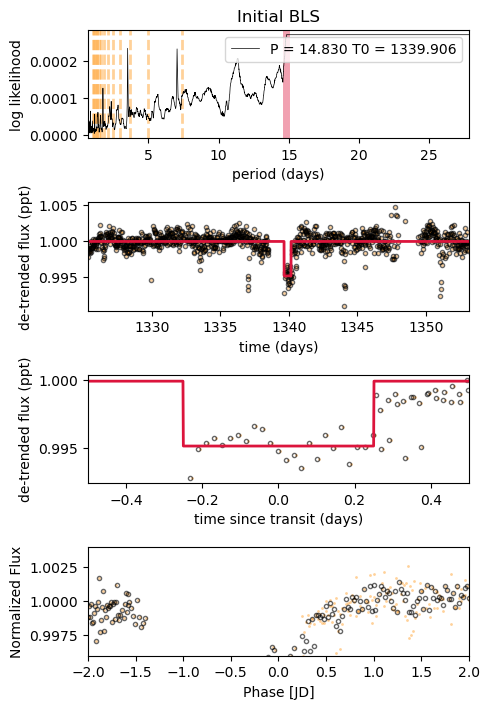

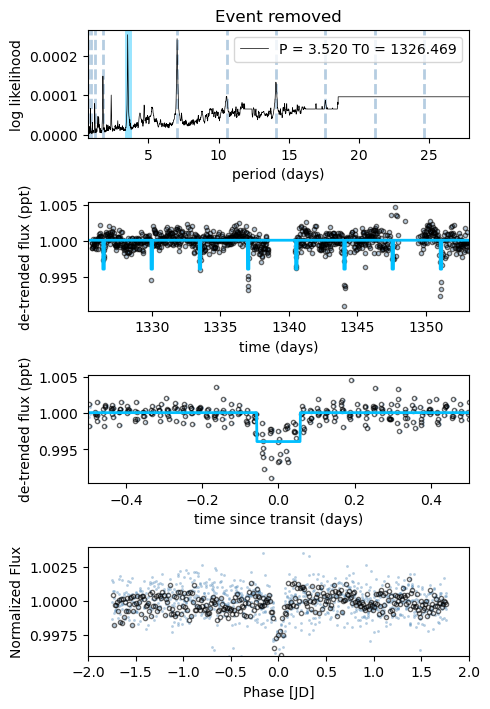

Some statistics about the two fits (these numbers are just estimates and should be taken with a large pinch of salt!)


,Period (days),T0 (TBJD),Transit depth (ppm),Odd depth (ppm),Even depth (ppm)
0,14.83,1339.905714,0.004756,0.000000,0.004756
1,3.52,1326.468630,0.003989,0.005648,0.002525


In [28]:
df = data_bls(lc)

print ("Some statistics about the two fits (these numbers are just estimates and should be taken with a large pinch of salt!)")
df